# High symmetry molecules

One special case, in which the `hqs_nmr` package can be extremely efficient are large molecules with a lot of symmetry groups. We are going to first elaborate again on the example of propane and then later on switch to a molecule with 22 spins.

Since this is the first example where performance is essential, we want to point out that it is important to **limit the number of threads** to the number of **physical cores** to avoid hyper-threading as it can actually lead to significant slow down for the largely linear algebra-based code.

You can do so for example, by closing this notebook and executing the following command in a shell:
```terminal
>>> export OMP_NUM_THREADS=<number of physical cores>
```
Afterwards you can open the notebook again in that shell.

Let us start as usual by importing all necessary modules. 

In [1]:
# NMR
from hqs_nmr.calculate import calculate_spectrum
from hqs_nmr.datatypes import NMRCalculationParameters, NMRSolverSettings
from hqs_nmr_parameters import read_parameters_yaml
from hqs_nmr_parameters.examples import molecules

# external modules
import matplotlib.pyplot as plt
import numpy as np

# only to plot molecular structures (optional)
from rdkit.Chem import Draw, MolFromSmiles

# Can be installed via HQStage and gives the plots a nice layout. This is an optional dependency.
import HQStyle
HQStyle.import_all()

# License check turned off.
/home/jkleinebuening/micromamba/envs/hqs-nmr/lib/python3.13/site-packages/hqs_nmr/solver/implementations/complete_solver.py:15: PerformanceWarning: Computation uses more threads than physical cores. Consider setting the OMP_NUM_THREADS environment variable to the number of physical cores: `export OMP_NUM_THREADS=12`.
  from hqs_quantum_solver.spins import (


Now we will shortly reproduce the steps of the [getting started tutorial](1_getting_started.ipynb), so importing the molecule parameters and solving the spectrum.

In [2]:
%%time
molecule = read_parameters_yaml("propane.yaml")
molecule_parameters = molecule.spin_system()
calculation_parameters = NMRCalculationParameters(field_T=11.7433)
spectrum_result = calculate_spectrum(molecule_parameters, calculation_parameters)
spectrum = spectrum_result.spectrum

CPU times: user 867 ms, sys: 8.98 ms, total: 876 ms
Wall time: 314 ms


As discussed in previous tutorials, by default we use a spin dependent clustering approach with a maximum cluster size of 12 spins. Since propane only has 8 spins, we are therefore calculating the spectrum exactly. By default only the $I^z$ conservation is taken into account. However, **HQS Spectrum Tools** can in principle also exploit local SU(2) symmetry, which can lead to a significant runtime improvement. It does so by automatically identifying magnetically equivalent spins. For more information check out the solver description in the [documentation](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/background/solver.html).
To enable this option, we have to adjust the `min_size_local_su2` attribute of the `NMRSolverSettings` dataclass. It defines the minimum size of a cluster, at which local SU(2) symmetry is still employed. This parameter is by default set to 13. We will see in a bit, why this is the case. Let's first repeat the calculation with the adjusted setting:

In [3]:
%%time
solver_settings = NMRSolverSettings(min_size_local_su2=7, verbose=1)
calculation_parameters = NMRCalculationParameters(field_T=11.7433, solver_settings=solver_settings)
spectrum_local_su2_result = calculate_spectrum(molecule_parameters, calculation_parameters)
spectrum_local_su2 = spectrum_result.spectrum
print("\n")

The following groups have been identified: 
[array([3, 4]), array([0, 1, 2, 5, 6, 7])]
The following groups have been identified: 
[array([3, 4]), array([0, 1, 2, 5, 6, 7])]


CPU times: user 793 ms, sys: 55.8 ms, total: 848 ms
Wall time: 469 ms


First notice that the output appears twice. This is because the solver backend is called twice. Once only with a few frequency points and large broadening and then a second time with a rediscretized frequency point distribution based on the result of the first calculation.
In the output, we can see that two symmetry groups were identified. These correspond to the two methyl groups which are combined into one spin and the other two hydrogens which form the second higher order spin.

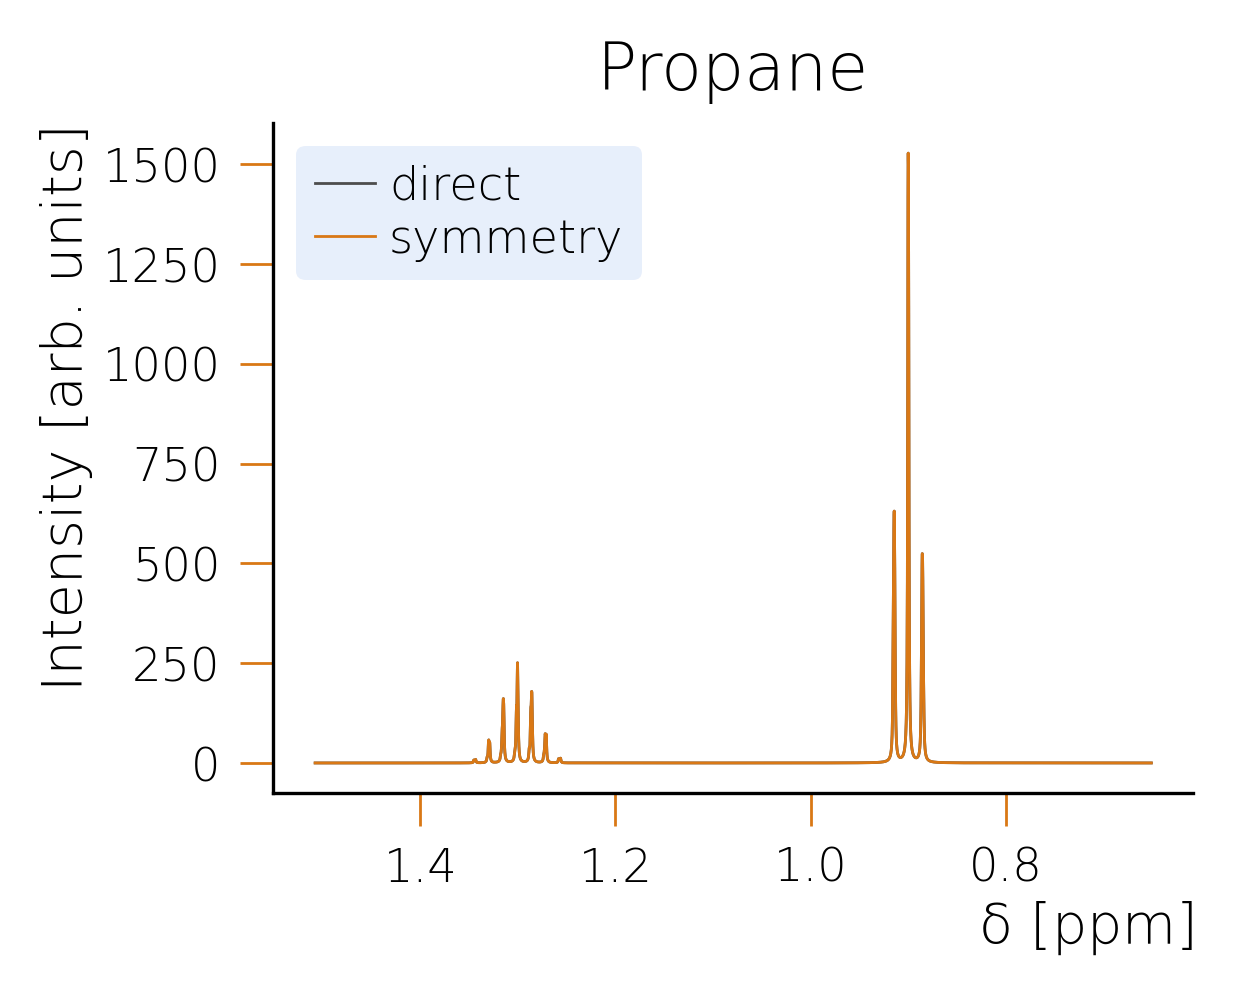

In [4]:
plt.plot(
    spectrum.omegas_ppm, np.sum(spectrum.spin_contributions, axis=0), label="direct", linewidth=0.5
)
plt.plot(
    spectrum_local_su2.omegas_ppm,
    np.sum(spectrum_local_su2.spin_contributions, axis=0),
    label="symmetry",
    linewidth=0.5,
)
plt.title("Propane")
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.legend()
plt.gca().invert_xaxis()
plt.show()

As you can see, we get indeed the same spectrum. However, now check out the runtimes. The first run without symmetry took around the same time, as the approach with symmetry. The reason for this is that exploiting the local SU(2) symmetry requires an additional loop over all $I^2$ quantum number sectors. This additional loop leads to computational overhead, increasing the runtime. However, when going to larger molecules, this overhead typically becomes negligible in comparison to the time it would take to diagonalize the largest block in the Hamiltonian without local SU(2) symmetry. This is why we set the attribute `min_size_local_su2` by default to 13.

To show you a striking example for this, let's take a more complex molecule 1,2-di-*tert*-butyl-diphosphane.

In [5]:
molecule = molecules["1,2-di-tert-butyl-diphosphane"]
molecule_parameters = molecule.spin_system()

Let's visualize it:

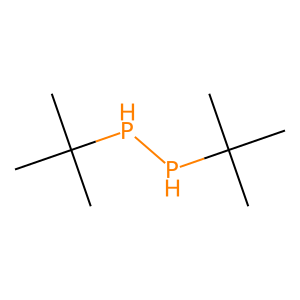

In [6]:
smiles_string = molecule.structures["SMILES"].content
molecule_image_info = MolFromSmiles(smiles_string)
Draw.MolToImage(molecule_image_info)

The molecule has in total 22 spins, with 3 methyl groups coupling symmetrically to one phosphorous atom and another three to another phosphorous atom. Each set of 3 methyl groups can be represented as one spin of higher order spin representation. Note that the two spins originating from the phosphor atom, also couple to two additional hydrogens. As we will see later, this additional coupling will lead to a more complex NMR spectrum as one might initially expect.

Now since the computation is still going to run for a while, let's first investigate where we would expect interesting spectral features. For this, we can simply use the default solver:

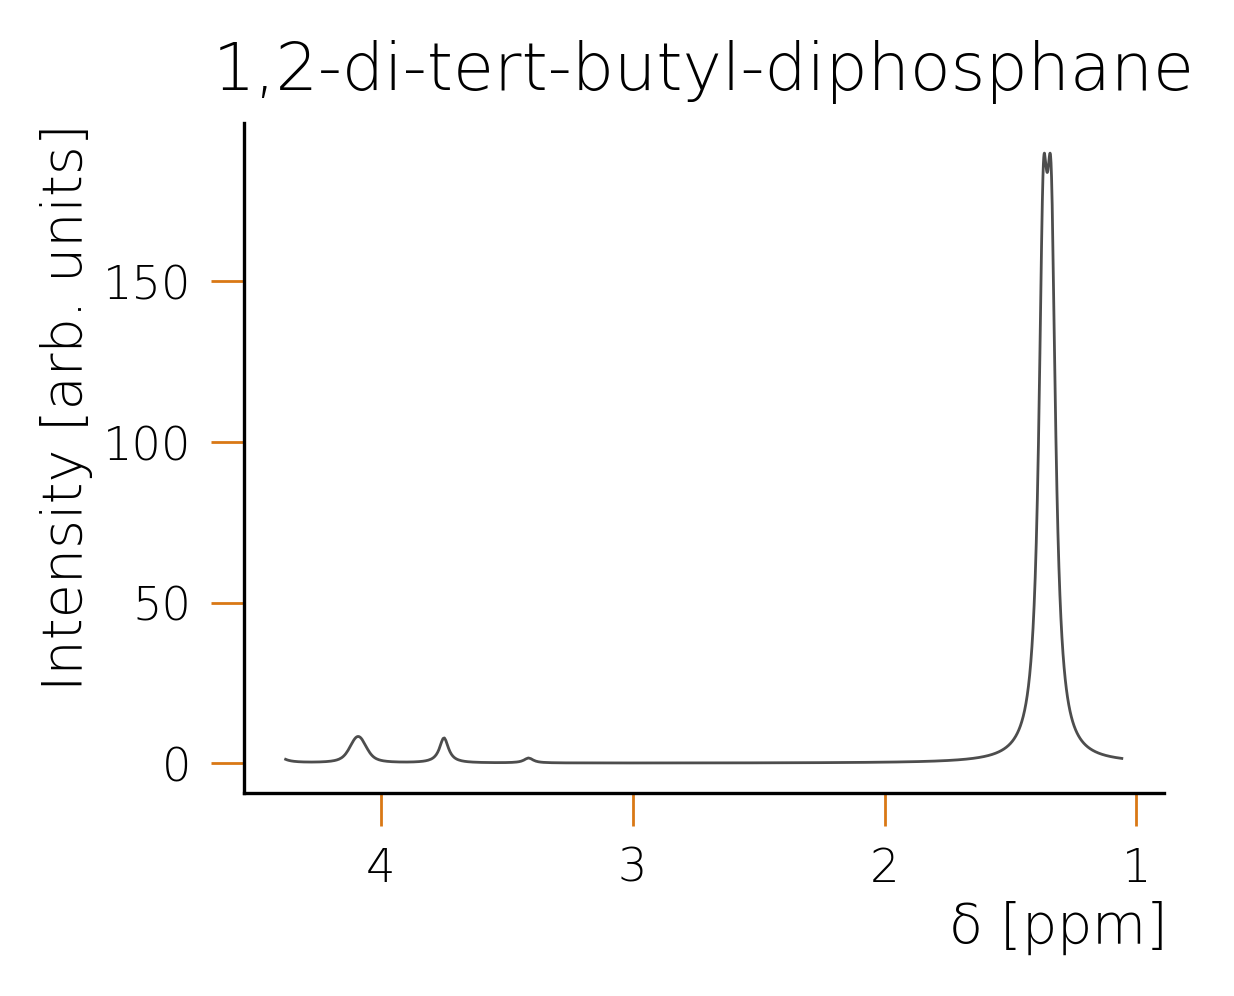

In [7]:
calculation_parameters = NMRCalculationParameters(field_T=11.7433)
result_spectrum = calculate_spectrum(molecule_parameters, calculation_parameters)
spectrum = result_spectrum.spectrum
plt.plot(spectrum.omegas_ppm, np.sum(spectrum.spin_contributions, axis=0), linewidth=0.5)
plt.title("1,2-di-tert-butyl-diphosphane")
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.gca().invert_xaxis()
plt.show()

To get an idea of which peaks are associated with which spins, let us print the chemical shifts:

In [8]:
print(molecule_parameters.shifts)

[-43.844, -43.844, 4.09, 1.354, 1.354, 1.354, 1.354, 1.354, 1.354, 1.354, 1.354, 1.354, 4.09, 1.354, 1.354, 1.354, 1.354, 1.354, 1.354, 1.354, 1.354, 1.354]


Considering the molecule structure shown earlier, we can identify the shifts of the phosphorus atoms to be &minus;43.844 ppm and so they are not shown in the spectrum, as we are measuring a proton NMR spectrum. Furthermore, we can identify the 18 hydrogens in the two symmetric groups to have a shift of 1.354 ppm and the two hydrogens coupling directly to the phosphorus atom to have a shift of 4.09 ppm. Since the `calculate_spectrum` function places more frequency points where there is more spectral weight, the spectrum is shifted quite a bit towards lower frequencies. However, let us say, we want to investigate the peaks associated with the two hydrogens directly coupling to the phosphorus atoms. We can do so by defining a frequency window, where we make sure to choose it wide enough to capture all the peaks of interest:

In [9]:
frequency_window_ppm = (3.0, 5.1)

Additionally, the resolution could be chosen a bit finer. We therefore set the peak broadening value (full width at half maximum) to 0.5 Hz:

In [10]:
fwhm_Hz = 0.5

Now we check again if we are happy with the spectral window and the resolution:

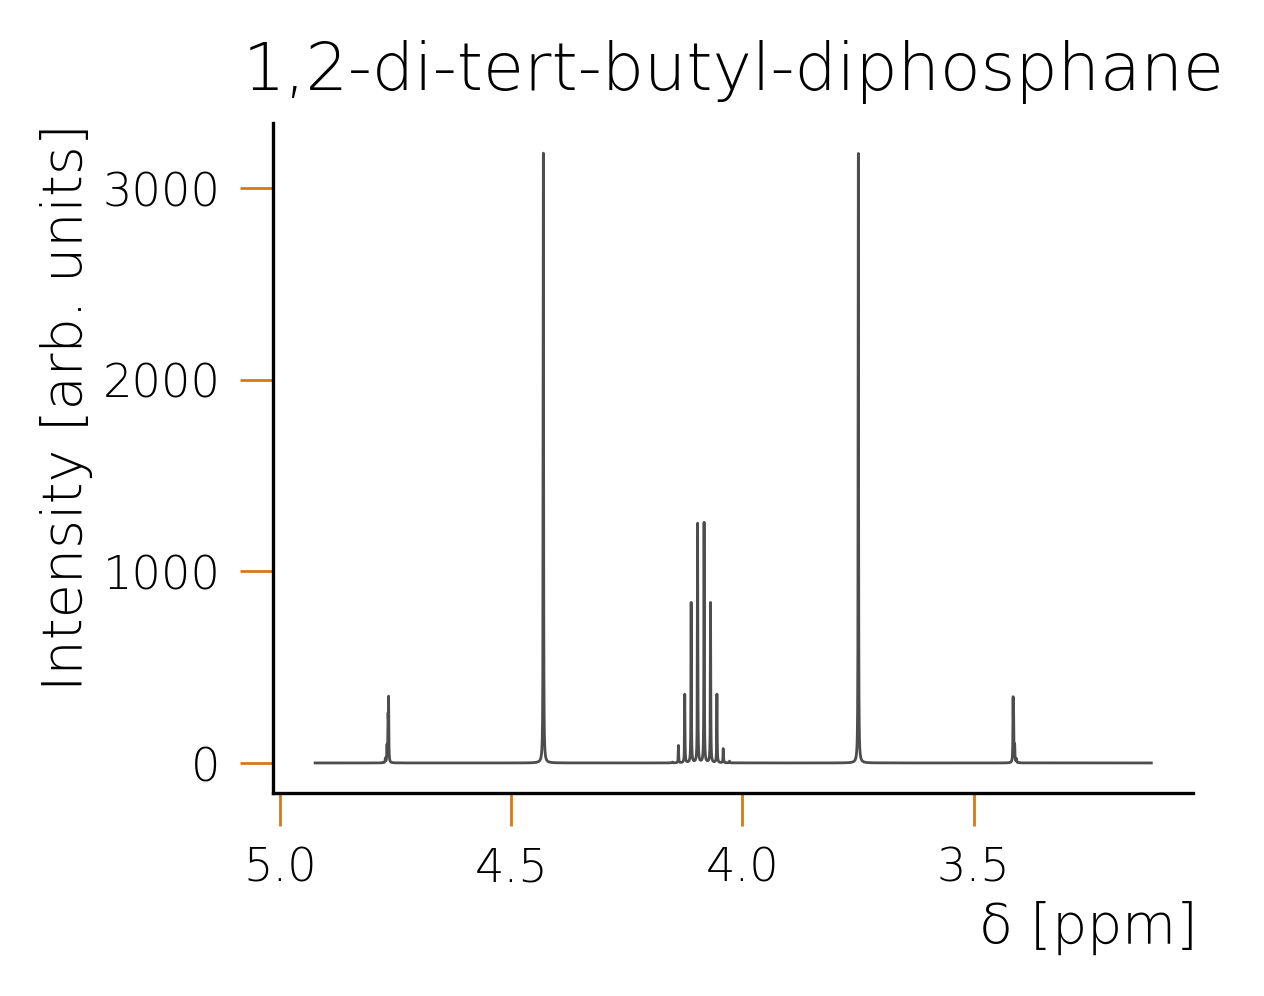

In [11]:
calculation_parameters = NMRCalculationParameters(
    field_T=11.7433, fwhm_Hz=fwhm_Hz, frequency_window_ppm=frequency_window_ppm
)
result_spectrum = calculate_spectrum(molecule_parameters, calculation_parameters)
spectrum = result_spectrum.spectrum
plt.plot(spectrum.omegas_ppm, np.sum(spectrum.spin_contributions, axis=0), linewidth=0.5)
plt.title("1,2-di-tert-butyl-diphosphane")
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.gca().invert_xaxis()
plt.show()

This looks already pretty good. Now let's see what we gain by solving the spectrum exactly. For this, we are going to use the same parameters, but we are going to set the additional flag `perform_clustering` to `False` in the `NMRSolverSettings` dataclass object. Note that because the molecule is larger than the value of the attribute `min_size_local_su2`, now local SU(2) symmetry is employed by default. To run the code, just comment in the code block below, however consider the note about runtime.

The following groups have been identified: 
[array([13, 14, 15, 16, 17, 18, 19, 20, 21]), array([ 3,  4,  5,  6,  7,  8,  9, 10, 11])]
The following groups have been identified: 
[array([13, 14, 15, 16, 17, 18, 19, 20, 21]), array([ 3,  4,  5,  6,  7,  8,  9, 10, 11])]


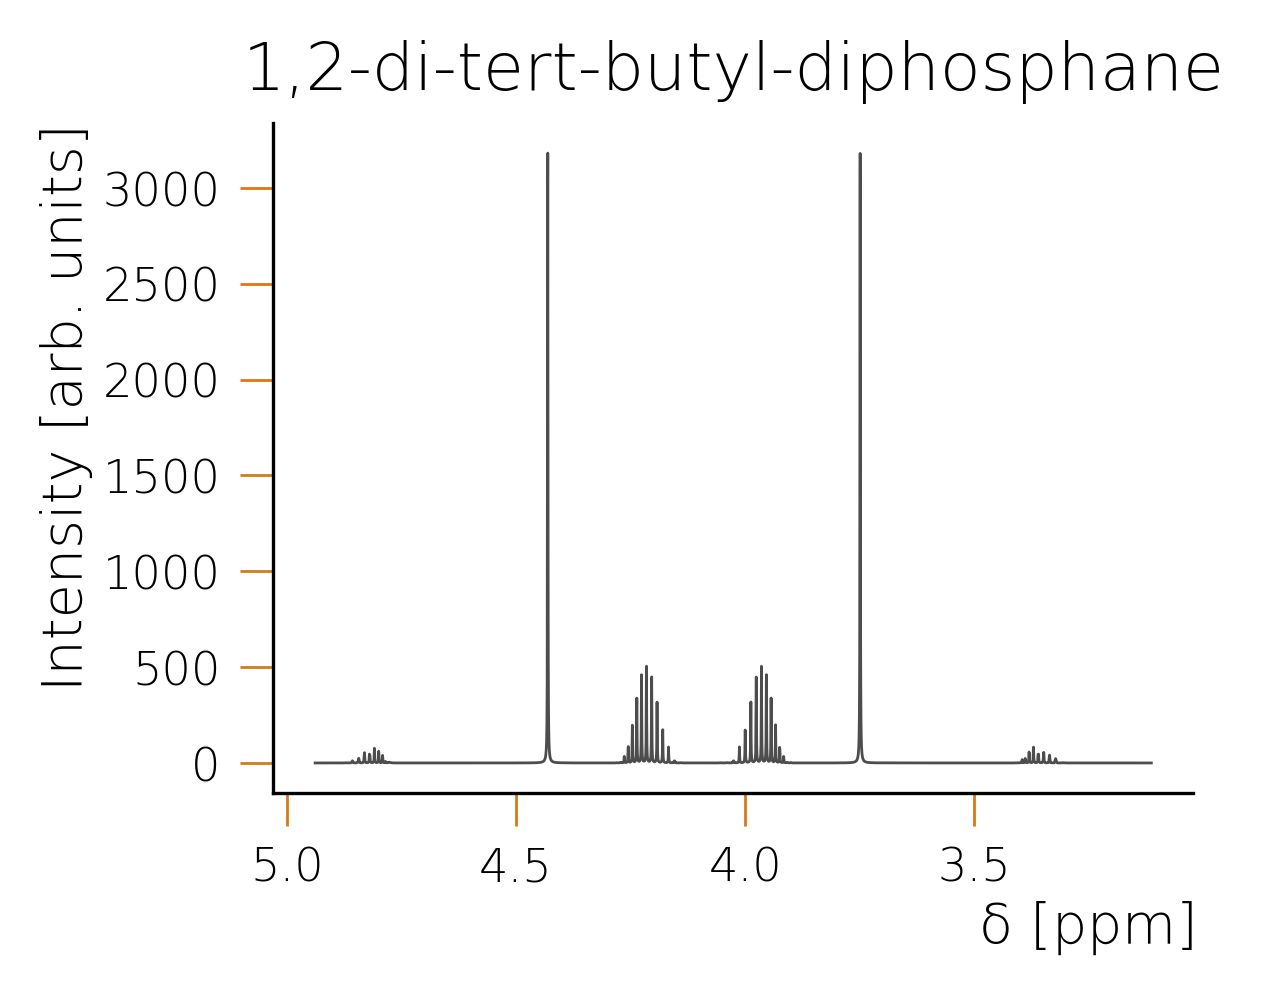

In [12]:
solver_settings = NMRSolverSettings(perform_clustering=False, verbose=1)
calculation_parameters = NMRCalculationParameters(
    field_T=11.7433,
    fwhm_Hz=fwhm_Hz,
    frequency_window_ppm=frequency_window_ppm,
    solver_settings=solver_settings,
)

# We ran this code on a laptop with 16GB RAM and 8 cores in under 30 minutes.
# NOTE: Make sure to limit the number of threads to the number of physical cores
# before you execute this code, as discussed in the beginning of this notebook.
result_spectrum = calculate_spectrum(molecule_parameters, calculation_parameters)
spectrum = result_spectrum.spectrum
plt.plot(spectrum.omegas_ppm, np.sum(spectrum.spin_contributions, axis=0), linewidth=0.5)
plt.title("1,2-di-tert-butyl-diphosphane")
plt.xlabel("$\\delta$ [ppm]")
plt.ylabel("Intensity [arb. units]")
plt.gca().invert_xaxis()
plt.show()

As you can see in the output, it identified two groups of 9 spins each, as we expected. While this calculation does take around 30 minutes, remember that a naive implementation would require a diagonalization of a hamiltonian matrix of dimension $2^{22}=4,194,304$. And even if $I^z$ conservation would be taken into account, which all but one of our solver do, the maximum dimension of the individual hamiltonian blocks would be $\binom{22}{11}=705,432$.

Finally, take a look at the actual spectrum. The results when solved exactly or approximately are actually quite different. Hence, for these highly symmetric molecules it might be worth taking the additional time to evaluate the spectrum exactly.